In [1]:
import logging
from torch.utils.data import DataLoader, random_split
import torch
import numpy as np

import os
import sys
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR

sys.path.append('/Data/reds_dataset/6.8300-Computer-Vision/src/')

from data_handlers.loading import MultiStageVideoDataset, VideoDataset
from models import MultiStageBasicVSR
from utils.loss import CharbonnierLoss
from utils.logging_config import logger_setup
from utils.arguments_parser import args_parser
from config import return_config
from utils.tester_multistage import test_loop
from utils.trainer_multistage import train_loop

In [1]:
val_dataset = MultiStageVideoDataset(
        lr_data_dir='/Data/reds_dataset/6.8300-Computer-Vision/data/processed/train/train_sharp_bicubic/X4',
        hr_data_dir='/Data/reds_dataset/6.8300-Computer-Vision/data/processed/train/train_sharp',
        rolling_window=5,
        is_test=False,
        is_val=True,
        patch_size=64,
    )
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4)

model = MultiStageBasicVSR(
        spynet_pretrained='/Data/reds_dataset/6.8300-Computer-Vision/checkpoints/spynet_20210409-c6c1bd09.pth',
        pretrained_model='/Data/reds_dataset/6.8300-Computer-Vision/checkpoints/basicvsr_custom_spynet.pth',
        rolling_window=5,
    )

state_dict = torch.load('/Data/reds_dataset/6.8300-Computer-Vision/results/multistage_bvsr_trial_fixed/models/model_10.pth')
state_dict = {k.replace('_orig_mod.',''): v for k, v in state_dict.items()}

model.load_state_dict(state_dict)
model = model.to('cuda')

model = model.eval()

# criterion = CharbonnierLoss()

device = 'cuda'
psnrs = []
for idx, data in enumerate(val_loader):
    gt_sequences, lq_sequences = data[1], data[0]
    gt_sequences = gt_sequences.to(device)
    (in_1, in_2, in_3) = (lq_sequences[0].to(device), lq_sequences[1].to(device), lq_sequences[2].to(device))    
    out = model((in_1, in_2, in_3))
    gt_sequences = gt_sequences.squeeze(1)
    mse = nn.MSELoss()
    loss = mse(out, gt_sequences)
    psnrs.append((10*torch.log(1/loss)/torch.log(torch.Tensor([10]).to('cuda'))).cpu().detach().numpy())
print(f'Average validation PSNR: {np.mean(psnrs)}dB')

NameError: name 'MultiStageVideoDataset' is not defined

In [6]:
test_dataset = MultiStageVideoDataset(
        lr_data_dir='/Data/reds_dataset/6.8300-Computer-Vision/data/processed/train/train_sharp_bicubic/X4',
        hr_data_dir='/Data/reds_dataset/6.8300-Computer-Vision/data/processed/train/train_sharp',
        rolling_window=5,
        is_test=True,
        is_val=False,
        patch_size=64,
    )
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)

psnrs = []
for idx, data in enumerate(test_loader):
    gt_sequences, lq_sequences = data[1], data[0]
    gt_sequences = gt_sequences.to(device)
    (in_1, in_2, in_3) = (lq_sequences[0].to(device), lq_sequences[1].to(device), lq_sequences[2].to(device))    
    out = model((in_1, in_2, in_3))
    gt_sequences = gt_sequences.squeeze(1)
    mse = nn.MSELoss()
    loss = mse(out, gt_sequences)
    psnrs.append((10*torch.log(1/loss)/torch.log(torch.Tensor([10]).to('cuda'))).cpu().detach().numpy())
print(f'Average test PSNR: {np.mean(psnrs)}dB')

Average test PSNR: 30.401750564575195dB


In [4]:
# get the train set
train_dataset = MultiStageVideoDataset(
        lr_data_dir='/Data/reds_dataset/6.8300-Computer-Vision/data/processed/train/train_sharp_bicubic/X4',
        hr_data_dir='/Data/reds_dataset/6.8300-Computer-Vision/data/processed/train/train_sharp',
        rolling_window=5,
        is_test=False,
        is_small_test=False,
        patch_size=64,
    )
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=4)

In [2]:
train_dataset = VideoDataset(
        lr_data_dir='/Data/reds_dataset/6.8300-Computer-Vision/data/processed/train/train_sharp_bicubic/X4',
        hr_data_dir='/Data/reds_dataset/6.8300-Computer-Vision/data/processed/train/train_sharp',
        rolling_window=5,
        is_test=False,
        is_small_test=False,
        patch_size=64,
    )
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=4)

In [3]:
device = 'cuda'
for idx, data in enumerate(train_loader):
    gt_sequences, lq_sequences = data[1], data[0]
    gt_sequences = gt_sequences.to(device)
    break

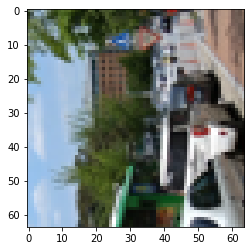

In [5]:
input_img = lq_sequences.squeeze(0)[2].cpu().detach().permute(1,2,0).numpy()
plt.imshow(input_img)

### With the model returning the output of the attention

In [5]:
device = 'cuda'
for idx, data in enumerate(train_loader):
    gt_sequences, lq_sequences = data[1], data[0]
    gt_sequences = gt_sequences.to(device)
    (in_1, in_2, in_3) = (lq_sequences[0].to(device), lq_sequences[1].to(device), lq_sequences[2].to(device))    
    out, attention_output, base, out_temp, (output_1, output_2, output_3) = model((in_1, in_2, in_3))
    gt_sequences = gt_sequences.squeeze(1)
    loss_batch = criterion(out, gt_sequences)
    print(loss_batch)
    break

/users/eleves-a/2019/paul.theron/miniconda3/envs/computer_vision/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


tensor(0.7766, device='cuda:0', grad_fn=<MulBackward0>)


In [10]:
input_img = in_1.squeeze(0)[2].cpu().detach().permute(1,2,0).numpy()

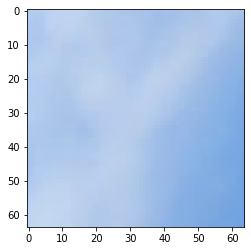

In [11]:
plt.imshow(input_img)

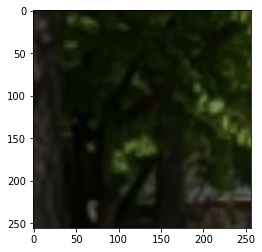

In [10]:
# display out
outb = out
outb = outb.permute(0,2,3,1)
plt.imshow(outb[0].cpu().detach().numpy())

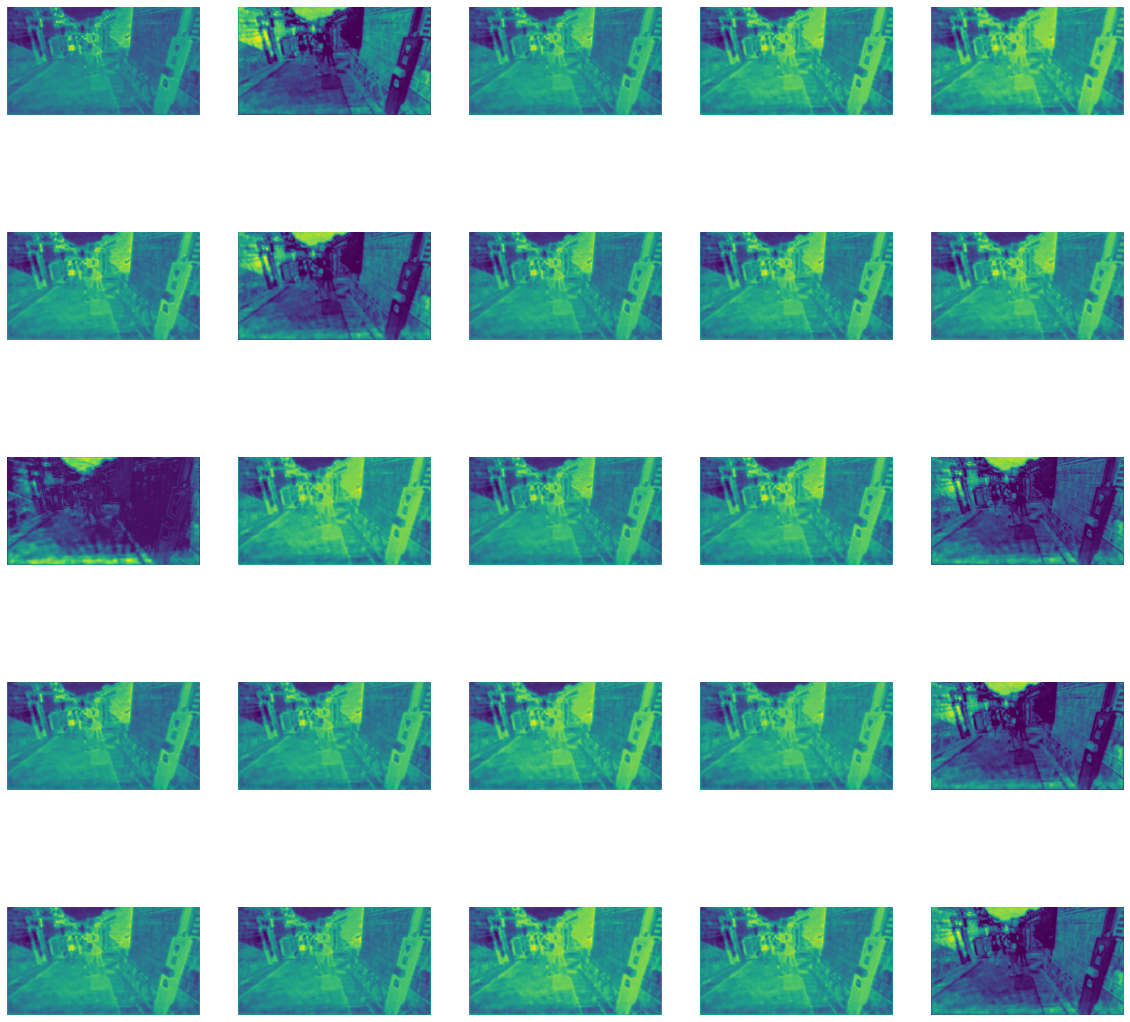

In [16]:
# plot it
fig, ax = plt.subplots(5, 5, figsize=(20, 20))
for i in range(5):
    for j in range(5):
        ax[i, j].imshow(attn_out[0, i*5+j, :, :].unsqueeze(0).detach().cpu().numpy().transpose(1, 2, 0))
        ax[i, j].axis('off')

### With the model returning the residuals

In [56]:
device = 'cuda'
for idx, data in enumerate(val_loader):
    gt_sequences, lq_sequences = data[1], data[0]
    gt_sequences = gt_sequences.to(device)
    (in_1, in_2, in_3) = (lq_sequences[0].to(device), lq_sequences[1].to(device), lq_sequences[2].to(device))
    out, base, res, (bvsr_1, bvsr_2, bvsr_3) = model((in_1, in_2, in_3))
    break

In [42]:
gt_sequences.shape

torch.Size([1, 1, 3, 720, 1280])

In [46]:
gt_sequences = gt_sequences.squeeze(0)


In [37]:
res.shape

torch.Size([1, 3, 720, 1280])

In [51]:
new_res = base + torch.sigmoid(res)

# retransform new_res between 0 and 1
new_res = (new_res - new_res.min())/(new_res.max() - new_res.min())


mse = nn.MSELoss()
loss = mse(new_res, gt_sequences)
psnr = 10*torch.log(1/loss)/torch.log(torch.Tensor([10]).to('cuda'))


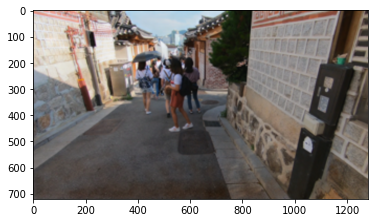

In [55]:
new_res = new_res.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
plt.imshow(new_res)

In [57]:
bvsr_1.min()

tensor(-0.1844, device='cuda:0')

In [52]:
psnr

tensor([23.8900], device='cuda:0', grad_fn=<DivBackward0>)

In [6]:
# min max scaling on out
#out = out - out.min()
#out = out / out.max()
#out = out.permute(0, 2, 3, 1).cpu().detach().numpy()
#plt.imshow(out[0])

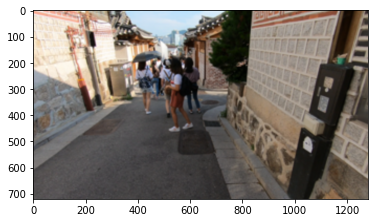

In [25]:
base = base.squeeze().permute(1, 2, 0).cpu().detach().numpy()
base = np.clip(base, 0, 1)
plt.imshow(base)

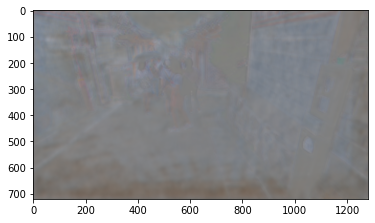

In [27]:
res = res.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
res = np.clip(res, 0, 1)
plt.imshow(res)

In [26]:
# apply a sigmoid on the tensor res
res = torch.sigmoid(res)

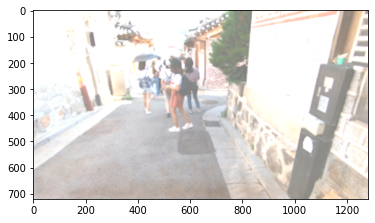

In [28]:
img_ = res + base

img_ = np.clip(img_, 0, 1)
plt.imshow(img_)

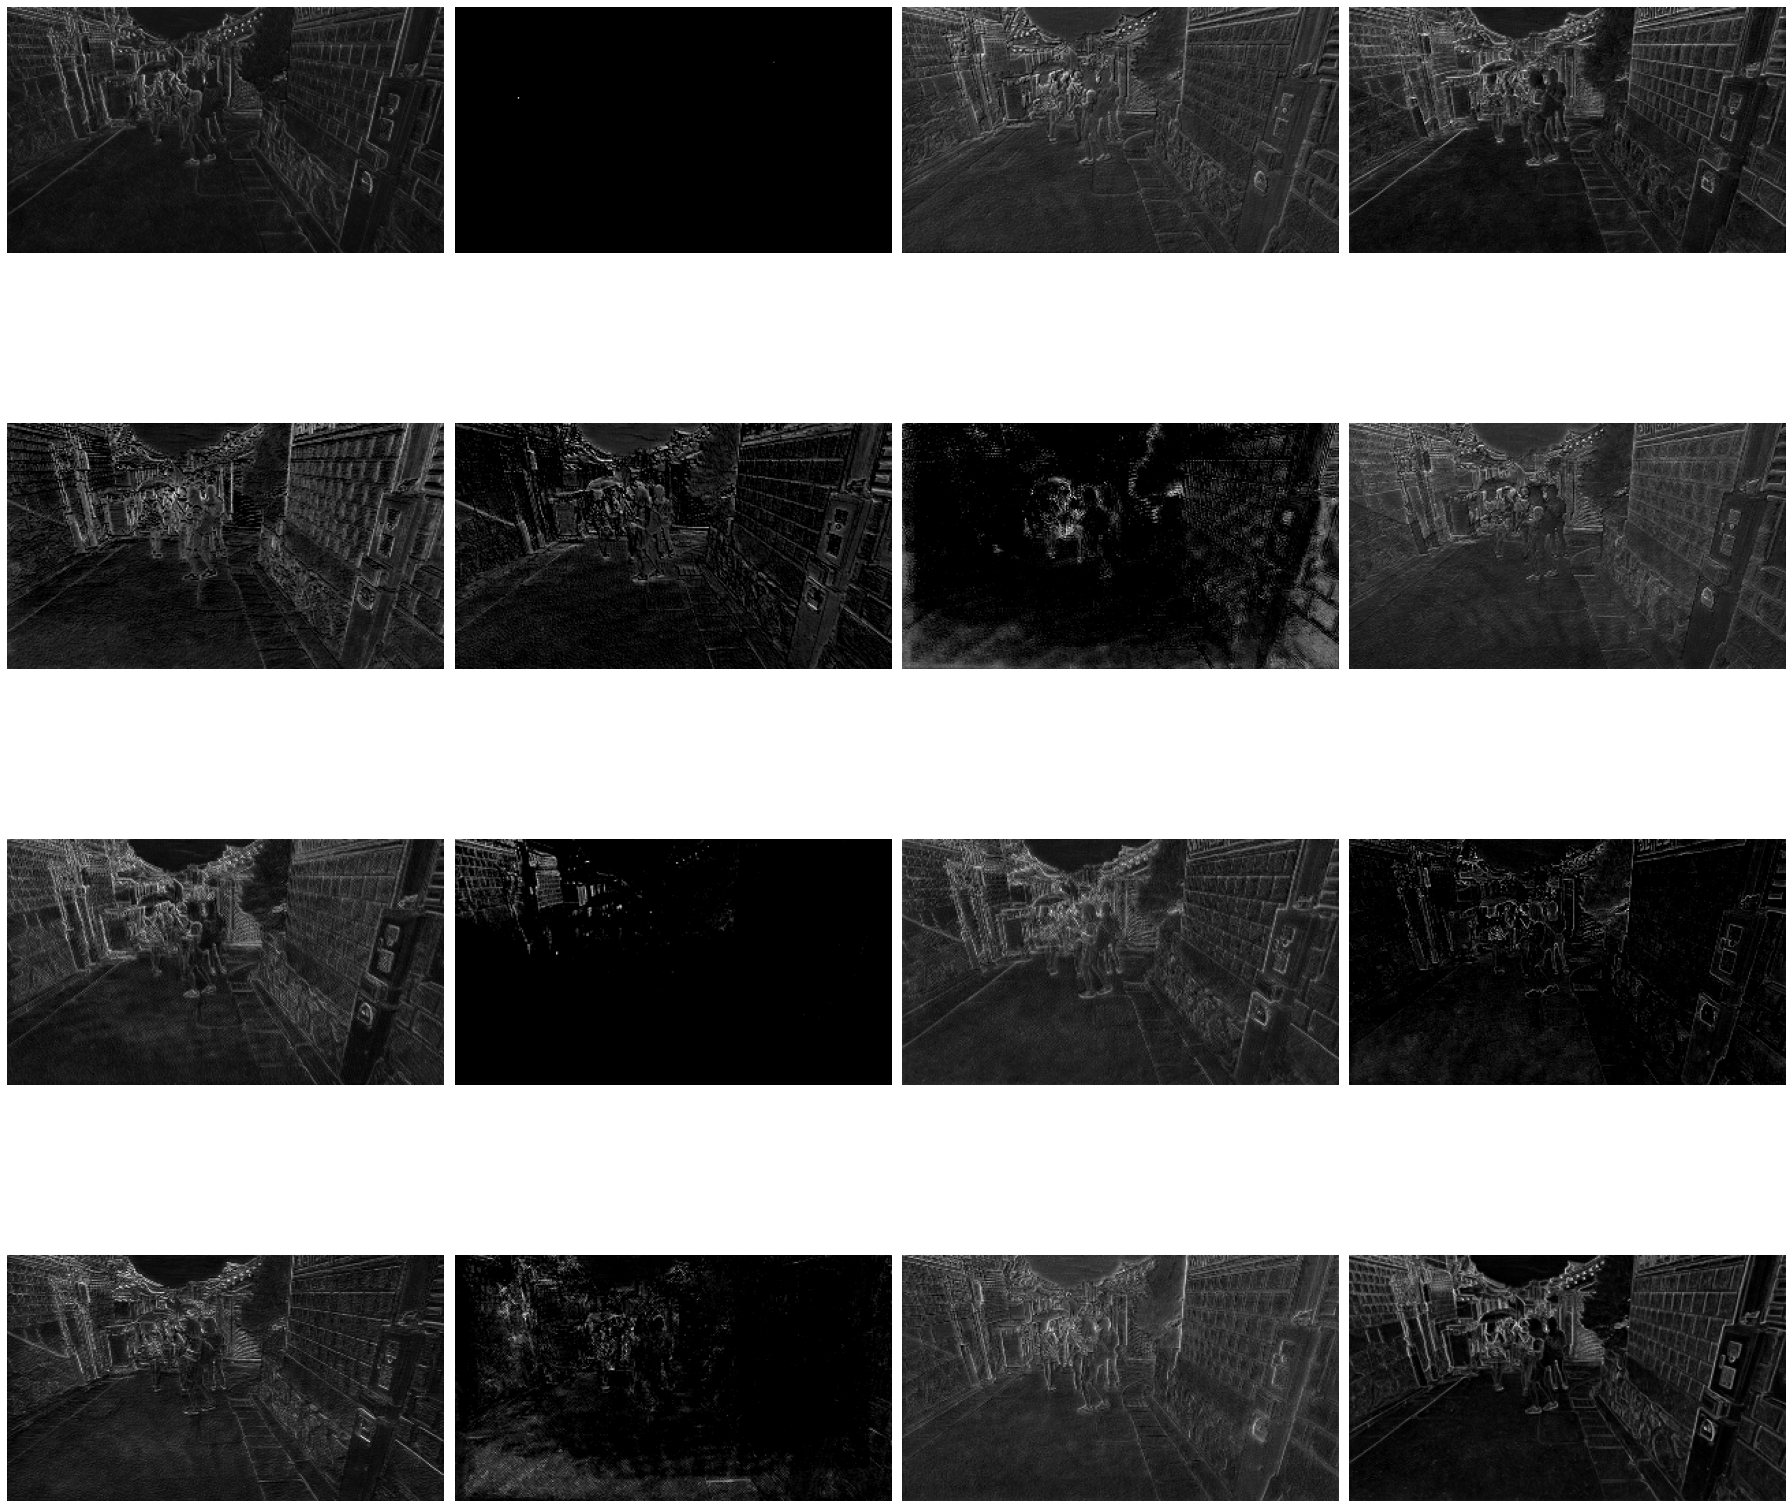

In [15]:
# print the 16 first channels of bvsr_c in black and white
bvsr_c = bvsr_2.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()

bvsr_c = np.clip(bvsr_c, 0, 1)

bvsr_c = bvsr_c[:, :, :16]

fig, axs = plt.subplots(4, 4, figsize=(25, 25))
for i in range(4):
    for j in range(4):
        axs[i, j].imshow(bvsr_c[:, :, i*4 + j], cmap='gray')
        axs[i, j].axis('off')
plt.tight_layout()    


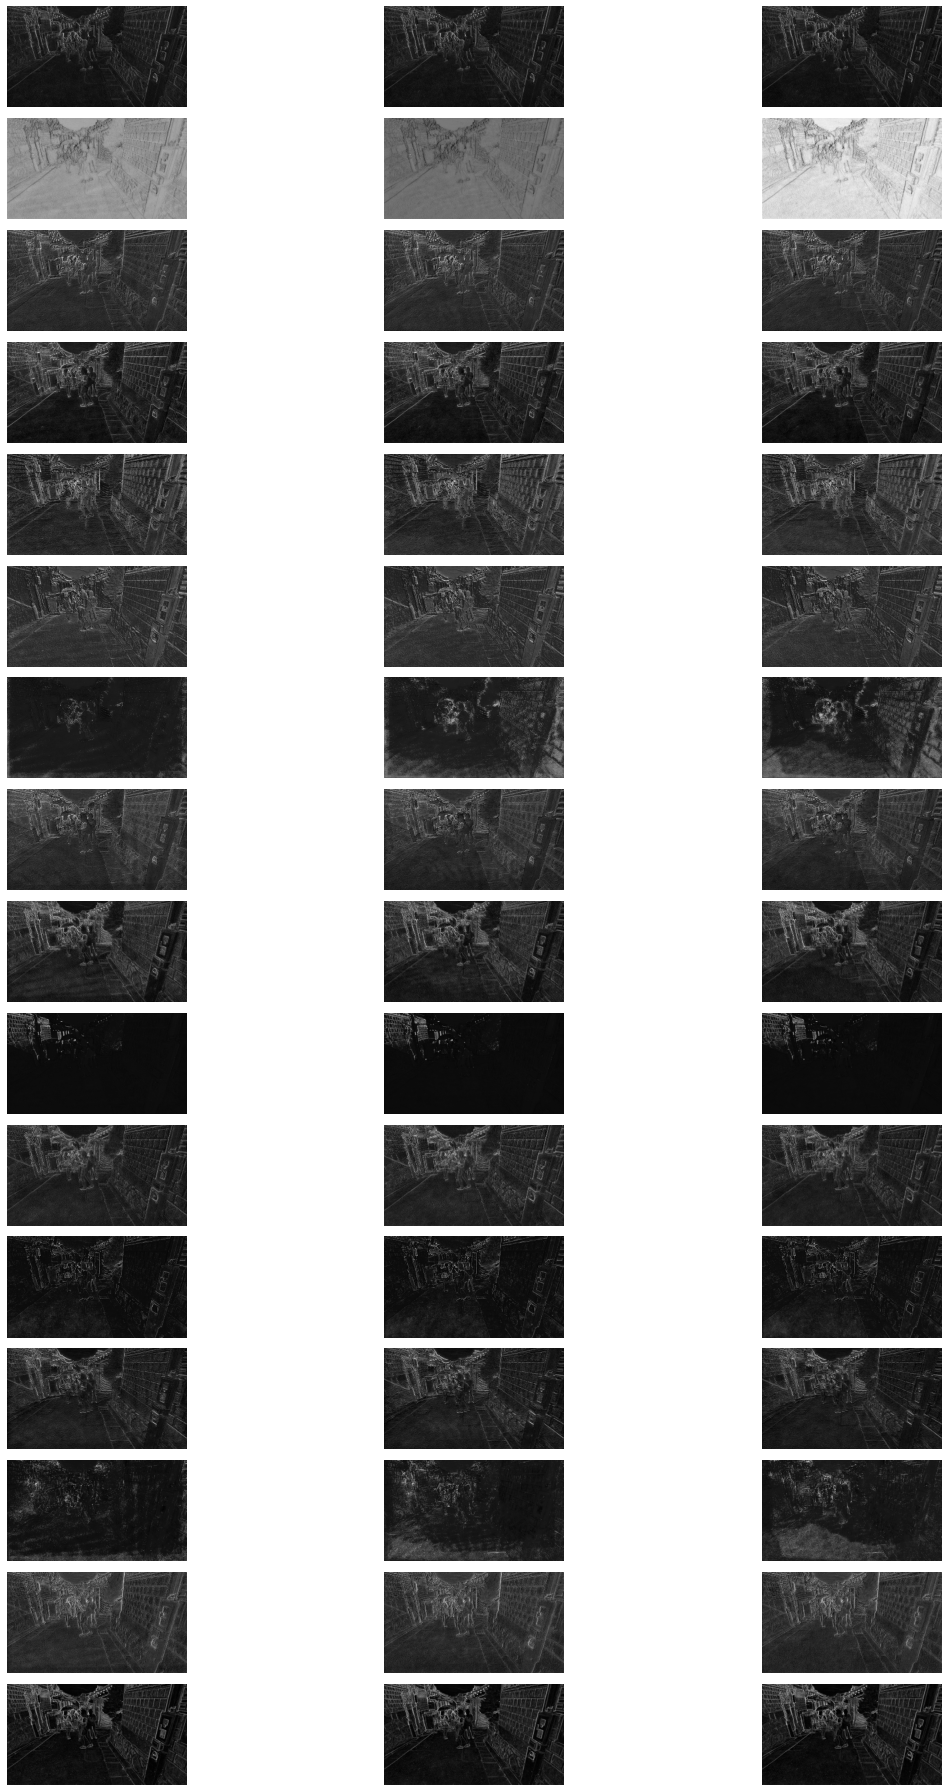

In [17]:
# on a fig with 16 lines and 3 columns, compare the channels of bvsr_1, bvsr_2, bvsr_3
bvsr_1_c = bvsr_1.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()[:, :, :16]
bvsr_2_c = bvsr_2.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()[:, :, :16]
bvsr_3_c = bvsr_3.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()[:, :, :16]

fig, ax = plt.subplots(16, 3, figsize=(25, 25))
for i in range(16):
    ax[i, 0].imshow(bvsr_1_c[:, :, i], cmap='gray')
    ax[i, 1].imshow(bvsr_2_c[:, :, i], cmap='gray')
    ax[i, 2].imshow(bvsr_3_c[:, :, i], cmap='gray')
    ax[i, 0].axis('off')
    ax[i, 1].axis('off')
    ax[i, 2].axis('off')
    plt.tight_layout()
plt.tight_layout()


In [ ]:
new_model = MultiStageBasicVSR(
        spynet_pretrained='/Data/reds_dataset/6.8300-Computer-Vision/checkpoints/spynet_20210409-c6c1bd09.pth',
        